In [1]:
import glob
import os
import cv2
import glob
import importlib
import h5py
import json
import copy
import _pickle as pkl
import numpy as np
import pandas as pd
import seaborn as sns
import pylab as pl
import matplotlib as mpl
import scipy.stats as spstats

In [2]:
import analyze2p.utils as hutils
import analyze2p.plotting as pplot

import analyze2p.receptive_fields.utils as rfutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.extraction.rois as roiutils
import analyze2p.retinotopy.utils as retutils
import analyze2p.retinotopy.segment as seg
import analyze2p.scatter as sct

In [3]:
rootdir = '/n/coxfs01/2p-data'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

basedir = os.path.join(aggregate_dir, 'FIGURES')
if not os.path.exists(basedir):
    os.makedirs(basedir)

traceid='traces001'
pplot.set_plot_params()

In [4]:
# Metadata
visual_areas=['V1', 'Lm', 'Li']
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
meta = sdata[sdata.experiment.isin(['rfs', 'rfs10'])].copy()

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets


In [88]:
# Receptive Field settings
experiment='rfs10'
va='V1'
response_type='dff'

meta['session_int'] = meta['session'].astype(int)

dsets = meta[(meta.experiment==experiment) & (meta.visual_area==va)
            & (meta['session_int']>=20190511)].copy()
dsets

,experiment,visual_area,datakey,fov,animalid,session,fovnum,session_int
192,rfs10,V1,20190613_JC097_fov1,FOV1_zoom2p0x,JC097,20190613,1,20190613
197,rfs10,V1,20190615_JC097_fov2,FOV2_zoom2p0x,JC097,20190615,2,20190615
199,rfs10,V1,20190616_JC097_fov1,FOV1_zoom2p0x,JC097,20190616,1,20190616
208,rfs10,V1,20190622_JC085_fov1,FOV1_zoom2p0x,JC085,20190622,1,20190622
213,rfs10,V1,20191004_JC110_fov2,FOV2_zoom2p0x,JC110,20191004,2,20191004
215,rfs10,V1,20191006_JC110_fov1,FOV1_zoom2p0x,JC110,20191006,1,20191006
220,rfs10,V1,20191111_JC117_fov1,FOV1_zoom2p0x,JC117,20191111,1,20191111


## Select dataset and create output dirs

In [89]:
# dk = '20191111_JC117_fov1
# dk ='20190617_JC097_fov1'
dk = '20191006_JC110_fov1'

## Select parameters

In [90]:
# RF settings
is_neuropil=True
do_spherical_correction=False
fit_thr=0.5

In [91]:
target_sigma_um=20
desired_radius_um=20
smooth_spline_x=1
smooth_spline_y=1
create_new=False
redo_smooth=True
is_neuropil=True
ds_factor=1

In [92]:
#### Some plotting stuff
scatter_kws={'s':2}

# Do it

#### Select output dirs

In [93]:
session, animalid, fovn = hutils.split_datakey_str(dk)
fovdir = glob.glob(os.path.join(rootdir, animalid, session, 'FOV%i_*' % fovn))[0]
curr_dst_dir = os.path.join(fovdir, 'segmentation')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)

/n/coxfs01/2p-data/JC110/20191006/FOV1_zoom2p0x/segmentation


#### Load (or calculate) segmentation results

In [94]:
retinorun = sct.get_best_retinorun(dk)
print(dk, retinorun)
gresults = sct.load_gradients(dk, va, retinorun, create_new=True)

20191006_JC110_fov1 retino_run1


In [95]:
grad_az = gresults['az_gradients']
grad_el = gresults['el_gradients']
AZMAP_NP = grad_az['image']
ELMAP_NP = grad_el['image']
GVECTORS = {'az': grad_az['vhat'], 'el': grad_el['vhat']}

area_mask = gresults['area_mask']


#### Calculate gradient vectors

In [96]:
importlib.reload(seg)
%matplotlib notebook

In [97]:
# azmap_full, elmap_full = sct.load_neuropil_background(dk, retinorun, 
#                                                      map_type='input')
# f

<IPython.core.display.Javascript object>


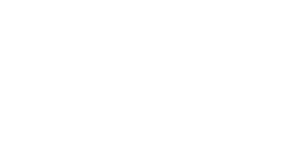

/n/coxfs01/2p-data/JC110/20191006/FOV1_zoom2p0x/segmentation


In [98]:
#### Plot gradients
spacing =200
scale = 0.0001 #0.0001
width = 0.01 #1 #0.01
headwidth=20
contour_lc='w'
contour_lw=1
cmap ='Spectral'
azmap_ = AZMAP_NP.copy()
elmap_ = ELMAP_NP.copy()
#curr_area_mask=area_mask.copy()
curr_area_mask = np.ones(area_mask.shape)
fig = seg.plot_gradients_in_area(curr_area_mask, azmap_, elmap_, 
                             grad_az, grad_el, cmap_phase=cmap,
                             contour_lc=contour_lc, contour_lw=contour_lw, 
                             spacing=spacing, 
                             scale=scale, width=width, headwidth=headwidth)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, hspace=0.8, top=0.8)
fig.text(0.05, 0.95, 'Gradients, est. from MOVINGBAR (%s)' % dk)

pl.savefig(os.path.join(curr_dst_dir, 'np_gradients.svg'))
print(curr_dst_dir)

In [99]:
np.nanmin(azmap_), np.nanmax(azmap_)

(16.8097433699523, 41.34548309093728)

In [100]:
np.nanmin(elmap_), np.nanmax(elmap_)

(-11.021777598975909, 2.6866617064855305)

#### Load Neuropil data points

Original dims: [512, 512]
Data were downsampled by 2.


<IPython.core.display.Javascript object>


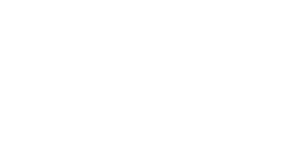

In [101]:
mag_thr=0.001
delay_map_thr=1.0
ds_factor=2
retinodf_np = sct.get_neuropil_data(dk, retinorun, mag_thr=mag_thr, 
                                delay_map_thr=delay_map_thr, ds_factor=ds_factor)
#### Plot MEASURED ctx on ret pos
fig = sct.scatter_ctx_vs_retino_by_cond(retinodf_np, 
                             az_x='ml_pos', az_y='x0', 
                             el_x='ap_pos', el_y='y0',
                             xlabel='meas. CTX pos (um)', 
                             ylabel='meas. RET pos (deg)')
fig.text(0.01, 0.95, 'BAR-estimated neuropil prefs. (%s)' % dk, fontsize=8)
figname = 'measured_ctx_vs_ret_BAR'
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
# print(curr_dst_dir, figname)

#### Use NEUROPIL to estimate linear model

<IPython.core.display.Javascript object>


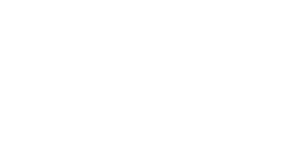

In [102]:
# 1. Align FOV to gradient vector direction ***FIX THIS TO REPLACE W TRANSMAT
aligned_, M = sct.align_cortex_to_gradient(retinodf_np, GVECTORS,
                                  xlabel='ml_pos', ylabel='ap_pos')
aligned_np = pd.concat([retinodf_np, aligned_], axis=1).dropna()

# PLOT POST-alignment (should be better)
fig = sct.scatter_ctx_vs_retino_by_cond(aligned_np, 
                             az_x='ml_proj', az_y='x0', 
                             el_x='ap_proj', el_y='y0',
                             xlabel='aligned CTX pos (um)', 
                             ylabel='meas. RET pos (deg)')
fig.text(0.01, 0.95, 'MOVINGBAR-estimated neuropil prefs. (%s)' % dk, fontsize=8)
figname = 'aligned_ctx_vs_measured_ret_BAR'
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
# print(curr_dst_dir, figname)

In [103]:
# 2. Fit model
REGR_NP = sct.regress_cortex_and_retino_pos(aligned_np, xvar='proj', model='ridge')
regr_np_meas = sct.regress_cortex_and_retino_pos(aligned_np, xvar='pos', model='ridge')
# Save
sct.update_models(dk, va, REGR_NP)

In [104]:
%matplotlib notebook

Measured ctx to y0: r=0.642 (p=0.000)
Aligned ctx to y0: r=0.680 (p=0.000)


<IPython.core.display.Javascript object>


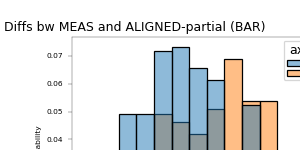

Text(0.01, 0.9, 'Diffs bw MEAS and ALIGNED-partial (BAR)')

In [105]:
r0, p0 = spstats.pearsonr(aligned_np['y0'].values, aligned_np['ap_pos'].values)
r1, p1 = spstats.pearsonr(aligned_np['y0'].values, aligned_np['ap_proj'].values)
print('Measured ctx to y0: r=%.3f (p=%.3f)' % (r0, p0))
print('Aligned ctx to y0: r=%.3f (p=%.3f)' % (r1, p1))

diffs_ml = aligned_np['ml_pos'].round(2)-aligned_np['ml_proj'].round(2)
diffs_ap = aligned_np['ap_pos'].round(2)-aligned_np['ap_proj'].round(2)
diffs_true_proj = pd.DataFrame({'ml': diffs_ml.abs(), 'ap': diffs_ap.abs()})
diffs_ = diffs_true_proj.stack().reset_index()\
            .rename(columns={'level_1': 'axis', 0: 'diff'})

fig, ax = pl.subplots(figsize=(4,3.5))
sns.histplot(diffs_, x='diff', hue='axis', ax=ax, stat='probability', 
             common_norm=True, common_bins=True)
pl.subplots_adjust(left=0.2, bottom=0.2)
fig.text(0.01, 0.9, 'Diffs bw MEAS and ALIGNED-partial (BAR)')

MEASURED:
|    |       R2 |    RMSE |   pearson_p |   pearson_r |   coefficient |   intercept | cond   |
|---:|---------:|--------:|------------:|------------:|--------------:|------------:|:-------|
|  0 | 0.581721 | 3.79328 | 5.38457e-65 |    0.762707 |     0.0219035 |     24.5842 | az     |
|  1 | 0.412603 | 3.91888 | 2.27994e-40 |    0.642342 |     0.013114  |    -13.4071 | el     |
ALIGNED:
|    |       R2 |    RMSE |   pearson_p |   pearson_r |   coefficient |   intercept | cond   |
|---:|---------:|--------:|------------:|------------:|--------------:|------------:|:-------|
|  0 | 0.624337 | 3.59486 | 8.82726e-73 |    0.79015  |     0.0212665 |     21.9939 | az     |
|  1 | 0.462352 | 3.74926 | 8.5974e-47  |    0.679965 |     0.0134316 |    -15.8664 | el     |


<IPython.core.display.Javascript object>


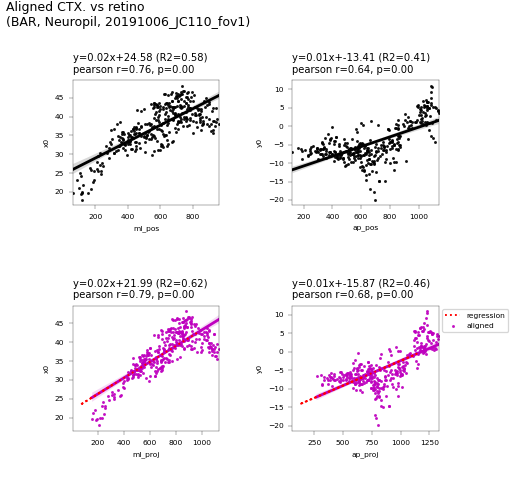

Text(0.01, 0.95, 'Aligned CTX. vs retino\n(BAR, Neuropil, 20191006_JC110_fov1)')

In [107]:
# Q:  why is reversal (LM) wonky
# Q:  fit SOMA to eitehr BAR or TILE gradient
print("MEASURED:")
print(regr_np_meas.to_markdown())
print("ALIGNED:")
print(REGR_NP.to_markdown())

fig = sct.plot_measured_and_aligned(aligned_np, REGR_NP, regr_np_meas)
fig.text(0.01, 0.95, 'Aligned CTX. vs retino\n(BAR, Neuropil, %s)' % dk)

#### Load soma

In [77]:
# fit_results, fit_params = rfutils.load_fit_results(dk, experiment=experiment)
# fit_results.keys()

In [78]:
df_soma = sct.get_soma_data(dk, experiment=experiment, retinorun=retinorun, 
                            protocol='TILE', traceid=traceid,
                            response_type=response_type,
                            do_spherical_correction=do_spherical_correction)
print(df_soma.shape)

adding pos
(53, 21)


<IPython.core.display.Javascript object>


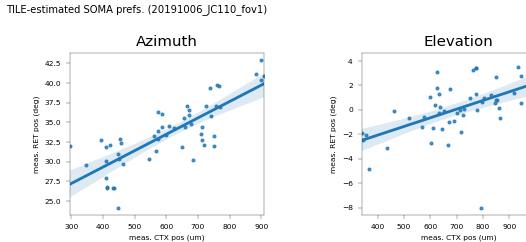

In [79]:
#### PLOT MEASURED soma pos. vs ret pos
fig = sct.scatter_ctx_vs_retino_by_cond(df_soma, 
                                 az_x='ml_pos', az_y='x0', 
                                 el_x='ap_pos', el_y='y0',
                                 xlabel='meas. CTX pos (um)', 
                                 ylabel='meas. RET pos (deg)')
fig.text(0.01, 0.95, 'TILE-estimated SOMA prefs. (%s)' % dk, fontsize=8)
figname = 'tile_measured_ctx_vs_ret_SOMA'
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
# print(curr_dst_dir, figname)

#### Align soma coords to gradient

In [80]:
aligned_, M = sct.align_cortex_to_gradient(df_soma, GVECTORS,
                                  xlabel='ml_pos', ylabel='ap_pos')
aligned_soma = pd.concat([df_soma, aligned_], axis=1).dropna().reset_index(drop=True)

MEASURED:
|    |       R2 |    RMSE |   pearson_p |   pearson_r |   coefficient |   intercept | cond   |
|---:|---------:|--------:|------------:|------------:|--------------:|------------:|:-------|
|  0 | 0.634804 | 2.42783 | 9.65017e-13 |    0.796746 |     0.0208531 |    20.9798  | az     |
|  1 | 0.314048 | 1.85025 | 1.27828e-05 |    0.560399 |     0.0071025 |    -4.90777 | el     |
ALIGNED:
|    |       R2 |    RMSE |   pearson_p |   pearson_r |   coefficient |   intercept | cond   |
|---:|---------:|--------:|------------:|------------:|--------------:|------------:|:-------|
|  0 | 0.686034 | 2.25111 | 1.97099e-14 |    0.828272 |    0.0194896  |     18.9048 | az     |
|  1 | 0.243367 | 1.94324 | 0.000174526 |    0.493323 |    0.00565686 |     -4.8417 | el     |


<IPython.core.display.Javascript object>


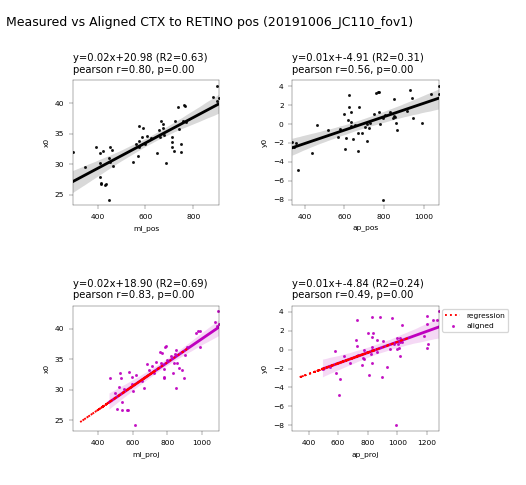

In [81]:
#### Align SOMA coords
regr_soma_meas = sct.regress_cortex_and_retino_pos(aligned_soma, 
                                                   xvar='pos', model='ridge')
regr_soma_proj = sct.regress_cortex_and_retino_pos(aligned_soma, 
                                                    xvar='proj', model='ridge')
print("MEASURED:")
print(regr_soma_meas.to_markdown())
print("ALIGNED:")
print(regr_soma_proj.to_markdown())
fig = sct.plot_measured_and_aligned(aligned_soma, regr_soma_proj, regr_soma_meas)
fig.text(0.01, 0.95, 'Measured vs Aligned CTX to RETINO pos (%s)' % dk)
figname = 'compared_measured_vs_aligned_CTX_to_RETINO'
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

#### Predict SOMA pos from retino preference

In [82]:
#### Predicted CORTICAL position (from retino position)
p_x = sct.predict_cortex_position(REGR_NP, cond='az', 
                          points=aligned_soma['x0'].values)
p_y = sct.predict_cortex_position(REGR_NP, cond='el', 
                          points=aligned_soma['y0'].values)
aligned_soma['predicted_ml_proj'] = p_x
aligned_soma['predicted_ap_proj'] = p_y

#### Predicted RETINO position (from cortical position)
r_x = sct.predict_retino_position(REGR_NP, cond='az', 
                          points=aligned_soma['ml_proj'].values)
r_y = sct.predict_retino_position(REGR_NP, cond='el', 
                          points=aligned_soma['ap_proj'].values)
aligned_soma['predicted_x0'] = r_x
aligned_soma['predicted_y0'] = r_y

In [83]:
#### Calculate inverse for visualizing on FOV
pred_INV = [np.linalg.inv(M).dot(np.array([x, y])) for (x, y) \
               in aligned_soma[['predicted_ml_proj', 'predicted_ap_proj']].values]
pred_inv_df = pd.DataFrame(pred_INV, columns=['pred_inv_x', 'pred_inv_y'], 
                      index=aligned_soma.index)
aligned_soma['predicted_ml_pos'] = pred_inv_df['pred_inv_x']
aligned_soma['predicted_ap_pos'] = pred_inv_df['pred_inv_y']

# Visualization

In [84]:
zimg, masks, ctrs = roiutils.get_masks_and_centroids(dk, experiment, traceid=traceid)
pixel_size = hutils.get_pixel_size()
zimg_r = retutils.transform_2p_fov(zimg, pixel_size)

<IPython.core.display.Javascript object>


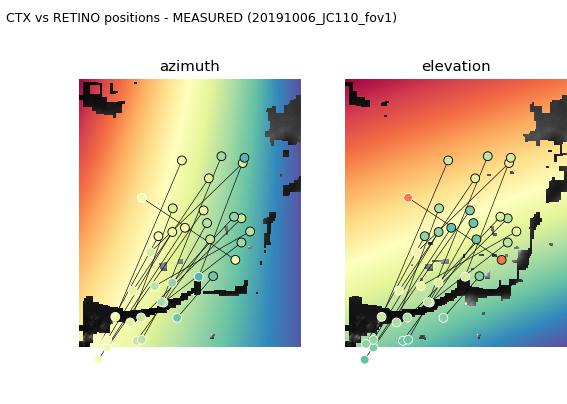

In [86]:
roi_interval = 1
cmap='Spectral'
plot_true=True
plot_predicted=True
plot_lines=True

color_true='k'
color_predicted='w'

markersize=50
lw=0.7
alpha=1

df_ = aligned_soma.copy().reset_index(drop=True)

# Make sure we are in bounds of FOV
max_ypos, max_xpos = AZMAP_NP.shape
incl_plotdf = df_[(df_['predicted_ml_pos']>=0) & (df_['predicted_ml_pos']<=max_xpos)
           & (df_['predicted_ap_proj']>=0) & (df_['predicted_ap_proj']<=max_ypos)].copy()
excl_ixs = [i for i in df_.index.tolist() if i not in incl_plotdf.index]
#plotdf = df_.loc[excl_ixs].copy()
plotdf = incl_plotdf.iloc[0::].copy()
# plotdf=df_.copy()

fig, axn = pl.subplots(1, 2, figsize=(7,5))
for ax, cond in zip(axn, ['azimuth', 'elevation']):
    neuropil_map = AZMAP_NP.copy() if cond=='azimuth' else ELMAP_NP.copy()
    retino_label='x0' if cond=='azimuth' else 'y0'
    # Set color limits
    vmin = min([np.nanmin(neuropil_map), plotdf[retino_label].min()])
    vmax = max([np.nanmax(neuropil_map), plotdf[retino_label].max()])
    normalize = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    ax.set_title(cond)
    ax.imshow(zimg_r, cmap='gray') #, vmin=abs_vmin, vmax=abs_vmax)
    ax.imshow(neuropil_map, cmap=cmap, vmin=vmin, vmax=vmax, alpha=alpha)
    if plot_predicted:
        # Plot soma
        sns.scatterplot(x='predicted_ml_pos', y='predicted_ap_pos', 
                data=plotdf, ax=ax,
                alpha=alpha, hue=retino_label, hue_norm=normalize, palette=cmap,
                s=markersize, linewidth=lw, edgecolor=color_predicted, zorder=1000) 
    if plot_lines:
        # Plot connecting line
        for (x1, y1), (x2, y2) in zip(\
                plotdf[['predicted_ml_pos', 'predicted_ap_pos']].values,
                plotdf[['ml_pos', 'ap_pos']].values):
            ax.plot([x1, x2], [y1, y2], lw=0.5, markersize=0, color='k')
    if plot_true:
        # Plot soma
        sns.scatterplot(x='ml_pos', y='ap_pos', data=plotdf, ax=ax,
                alpha=alpha, hue=retino_label, hue_norm=normalize, palette=cmap,
                s=markersize, linewidth=lw, edgecolor=color_true, zorder=1000) 
for ax in axn:
    ax.legend_.remove()
    ax.axis('off')
    
fig.text(0.01, 0.95, 'CTX vs RETINO positions - MEASURED (%s)' % dk)

figname = 'scatter_example'
#pl.savefig(os.path.join(basedir, '%s.svg' % figname))


In [87]:
df_soma.shape

(53, 21)

# Calculate scatter

<IPython.core.display.Javascript object>


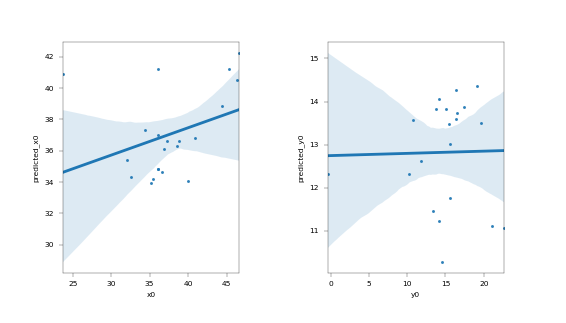

In [34]:
fig, axn = pl.subplots(1,2, figsize=(7,4))
ax=axn[0]
sns.regplot('x0', 'predicted_x0', data=aligned_soma, ax=ax, scatter_kws=scatter_kws)
ax=axn[1]
sns.regplot('y0', 'predicted_y0', data=aligned_soma, ax=ax, scatter_kws=scatter_kws)
pl.subplots_adjust(bottom=0.24, right=0.8, left=0.1, hspace=0.5, wspace=0.5)

In [35]:
deviations = sct.get_deviations(aligned_soma)

<IPython.core.display.Javascript object>


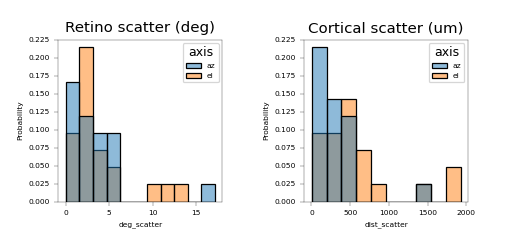

In [36]:
%matplotlib notebook
fig, axn = pl.subplots(1,2, figsize=(6.5, 3))


ax=axn[0]
sns.histplot(deviations, x='deg_scatter', hue='axis', ax=ax,
            stat='probability', cumulative=False )
ax.set_title('Retino scatter (deg)')
ax=axn[1]
sns.histplot(deviations, x='dist_scatter', hue='axis', ax=ax,
            stat='probability', cumulative=False)
ax.set_title('Cortical scatter (um)')
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.25, top=0.85, wspace=0.5, hspace=0.5)
